In [1]:
import pyart
import glob
import numpy as np
import matplotlib.pyplot as plt

# import cartopy.crs as ccrs


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



The code initially attempts hydrometeor classification without radar frequency information for band selection.


In [2]:
hour = "19"
day = "25"
month = "08"
year = "2022"

glob_str = f"/Users/bhupendra/projects/sail/data/test/gucxprecipradarcmacS2.c1.{year}{month}{day}.{hour}*"
files = sorted(glob.glob(glob_str))
files

['/Users/bhupendra/projects/sail/data/test/gucxprecipradarcmacS2.c1.20220825.194643.nc']

/Users/bhupendra/forked_repo/pyart/pyart/io/cfradial.py:412: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/Users/bhupendra/forked_repo/pyart/pyart/io/cfradial.py:412: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]


(-20.0, 20.0)

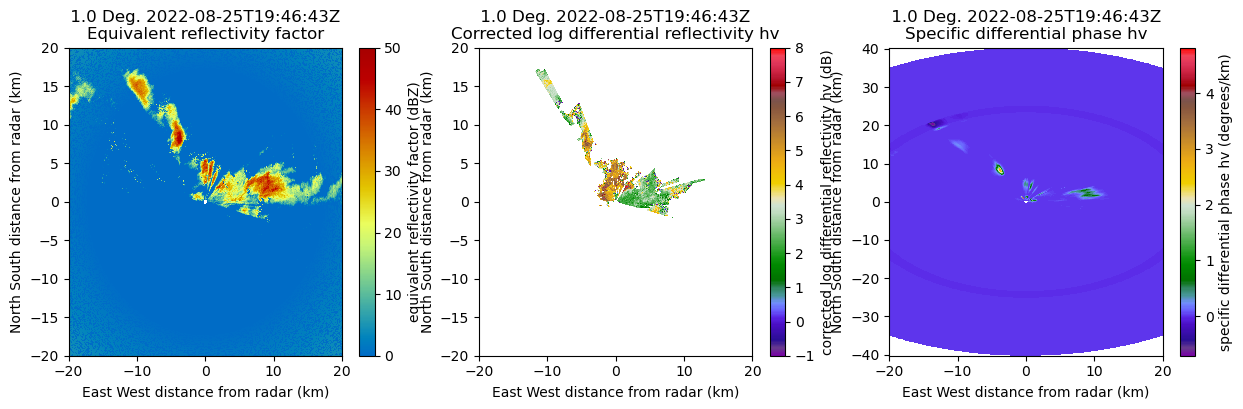

In [3]:
radar = pyart.io.read(files[0])
radar = radar.extract_sweeps([0])
figure = plt.figure(figsize=(15, 4))

ax1 = plt.subplot(1, 3, 1)
display = pyart.graph.RadarDisplay(radar)
ax1 = display.plot("DBZ", vmin=0, vmax=50)  # DBZ corrected_reflectivity
plt.xlim(-20, 20)
plt.ylim(-20, 20)

ax2 = plt.subplot(1, 3, 2)
ax2 = display.plot("corrected_differential_reflectivity", cmap="pyart_Carbone42")  # ZDR
plt.xlim(-20, 20)
plt.ylim(-20, 20)

ax3 = plt.subplot(1, 3, 3)
ax3 = display.plot("corrected_specific_diff_phase", cmap="pyart_Carbone42")  # KDP
plt.xlim(-20, 20)

### When instrument parameters does not have radar frequency info.

In [4]:
radar.instrument_parameters

{'nyquist_velocity': {'long_name': 'Nyquist velocity',
  'units': 'm/s',
  'standard_name': 'nyquist_velocity',
  'data': masked_array(data=[15.9, 15.9, 15.9, ..., 15.9, 15.9, 15.9],
               mask=False,
         fill_value=1e+20)}}

The shows an issue where radar frequency information is missing. Without this hydrometeor classification will default to C-band.

In [5]:
# Get classification
hydromet_class = pyart.retrieve.hydroclass_semisupervised(
    radar,
    refl_field="corrected_reflectivity",
    zdr_field="corrected_differential_reflectivity",
    kdp_field="filtered_corrected_specific_diff_phase",
    rhv_field="RHOHV",
    temp_field="sounding_temperature",
)

radar.add_field("hydro_classification", hydromet_class, replace_existing=True)

/Users/bhupendra/forked_repo/pyart/pyart/retrieve/echo_class.py:687: UserWarning: Radar instrument parameters and radar_freq param are empty.So frequency is unknown. Default coefficients for C band will be applied.
  warn(


# Use `radar_freq` parameters
To address this issue, radar frequency information can be supplied to the function with `radar_freq` parameter.

In [17]:
# Get classification
hydromet_class = pyart.retrieve.hydroclass_semisupervised(
    radar,
    refl_field="corrected_reflectivity",
    zdr_field="corrected_differential_reflectivity",
    kdp_field="filtered_corrected_specific_diff_phase",
    rhv_field="RHOHV",
    temp_field="sounding_temperature",
    radar_freq=9.2e9,
)

radar.add_field("hydro_classification", hydromet_class, replace_existing=True)

/Users/bhupendra/forked_repo/pyart/pyart/retrieve/echo_class.py:682: UserWarning: Radar instrument parameters are empty. Using user-supplied radar frequency: 9200000000.0
  warn(


#### Add radar frequency to the radar object
Incorporating radar frequency into the radar object enhances processing pipeline.

In [6]:
# Add X-band frequency information to radar.instrument_parameters
radar.instrument_parameters["frequency"] = {
    "long_name": "Radar frequency",
    "units": "Hz",
    "data": [9.2e9],
}

radar.instrument_parameters

{'nyquist_velocity': {'long_name': 'Nyquist velocity',
  'units': 'm/s',
  'standard_name': 'nyquist_velocity',
  'data': masked_array(data=[15.9, 15.9, 15.9, ..., 15.9, 15.9, 15.9],
               mask=False,
         fill_value=1e+20)},
 'frequency': {'long_name': 'Radar frequency',
  'units': 'Hz',
  'data': [9200000000.0]}}

Let's run the classification again and the warning should change telling the radar frequency from instrument parameters is used.


In [7]:
hydromet_class = pyart.retrieve.hydroclass_semisupervised(
    radar,
    refl_field="corrected_reflectivity",
    zdr_field="corrected_differential_reflectivity",
    kdp_field="filtered_corrected_specific_diff_phase",
    rhv_field="RHOHV",
    temp_field="sounding_temperature",
    radar_freq=9.2e9,
)

radar.add_field("hydro_classification", hydromet_class, replace_existing=True)

/Users/bhupendra/forked_repo/pyart/pyart/retrieve/echo_class.py:679: UserWarning: Using radar frequency from instrument parameters: 9200000000.0
  warn(f"Using radar frequency from instrument parameters: {frequency}")


Note that the frequency used here is from the radar object, not the user supplied.

## plotting

In [20]:
import matplotlib.colors as colors

hid_colors = [
    "White",
    "LightBlue",
    "MediumBlue",
    "DarkOrange",
    "LightPink",
    "Cyan",
    "DarkGray",
    "Lime",
    "Yellow",
    "Red",
    "Fuchsia",
]
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])


def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(
        [
            "Drizzle",
            "Rain",
            "Ice Crystals",
            "Aggregates",
            "Wet Snow",
            "Vertical Ice",
            "LD Graupel",
            "HD Graupel",
            "Hail",
            "Big Drops",
        ]
    )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb


def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(
            ["R(Kdp, Zdr)", "R(Kdp)", "R(Z, Zdr)", "R(Z)", "R(Zrain)"]
        )
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(
            ["R(Kdp, Zdr)", "R(Kdp)", "R(Z, Zdr)", "R(Z_all)", "R(Z_c)", "R(Z_s)"]
        )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb


def two_panel_plot(
    radar,
    sweep=0,
    var1="corrected_reflectivity",
    vmin1=0,
    vmax1=65,
    cmap1="RdYlBu_r",
    units1="dBZ",
    var2="corrected_differential_reflectivity",
    vmin2=-5,
    vmax2=5,
    cmap2="RdYlBu_r",
    units2="dB",
    return_flag=False,
    xlim=[-150, 150],
    ylim=[-150, 150],
):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13, 5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(
        var1,
        sweep=sweep,
        vmin=vmin1,
        vmax=vmax1,
        cmap=cmap1,
        colorbar_label=units1,
        mask_outside=True,
    )
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(
        var2,
        sweep=sweep,
        vmin=vmin2,
        vmax=vmax2,
        cmap=cmap2,
        colorbar_label=units2,
        mask_outside=True,
    )
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

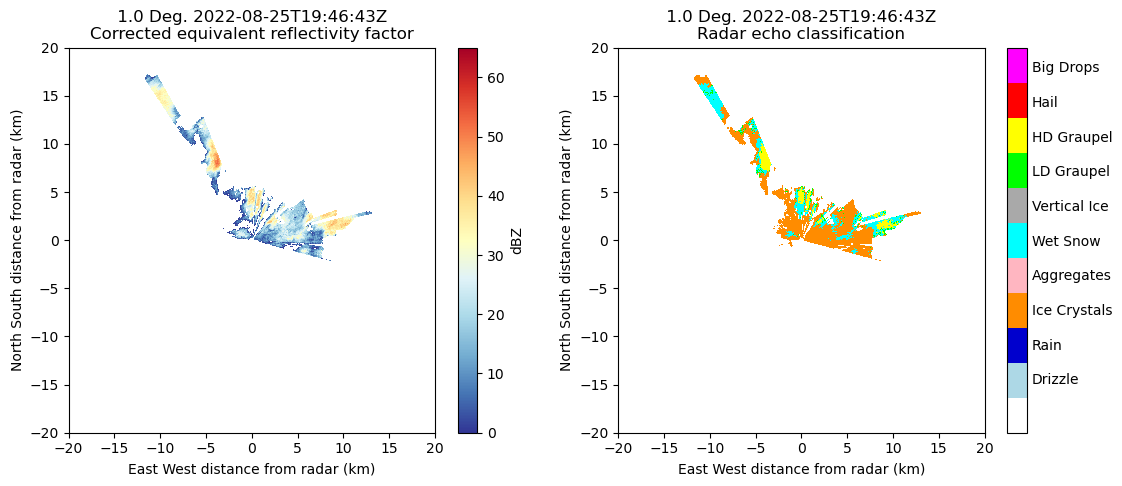

In [21]:
lim = [-20, 20]
fig, ax1, ax2, display = two_panel_plot(
    radar,
    sweep=0,
    var1="corrected_reflectivity",
    var2="hydro_classification",
    vmin2=0,
    vmax2=10,
    cmap2=cmaphid,
    units2="",
    return_flag=True,
    xlim=lim,
    ylim=lim,
)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])